# 1. quick start

In [74]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [75]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

将`Dataset`作为参数传递给`DataLoader`。在我们的数据集上包裹了一个可迭代的，并支持自动批处理、采样、洗牌和多进程数据加载。

定义一个64个批次大小，即可迭代数据加载器中的每个元素将返回一批64个功能和标签。

`DataLoader`支持 map 、迭代对数据进行处理。
* map: 是一个 tensor 到 tensor 的映射, 即: X -> y；
* 迭代: 是一个 list(tensor) 的列表, 即: (X, y);

In [76]:
batch_size = 64

training_loader = DataLoader(dataset=training_data, batch_size=batch_size)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

for X, y in training_loader: # type: (np.ndarray, np.ndarray)
    print(X.shape, y.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


## mac torch 加速 mps

In [77]:
torch.backends.mps.is_available(), torch.backends.mps.is_built()

(True, True)

In [78]:
device = torch.device('mps')
# 指定 device
torch.rand((3, 2), device=device)

tensor([[0.6393, 0.9914],
        [0.5151, 0.0716],
        [0.9402, 0.9957]], device='mps:0')

# 2. tensor

`tensor`类似于 NumPy 的`ndarray`s，只是张量可以在GPU或其他硬件加速器上运行。
事实上，`tensor`和 NumPy 数组通常可以共享相同的底层内存，无需复制数据。

## tensor 和 numpy 转换

tensor 转换为 numpy 数组

In [79]:
t = torch.ones(5)
t.numpy()

array([1., 1., 1., 1., 1.], dtype=float32)

numpy 数组 转换为 tensor

In [80]:
n = np.ones(5)
torch.from_numpy(n)

tensor([1., 1., 1., 1., 1.], dtype=torch.float64)

In [81]:
shape = (2,3)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.3030, 0.1234, 0.9488],
        [0.4487, 0.7536, 0.2179]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [82]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


# 3. 数据集和数据加载器

PyTorch提供两个数据原型：`torch.utils.data.DataLoader`和`torch.utils.data.Dataset`，允许您使用预加载的数据集以及您自己的数据。
`Dataset` 存储样本及其相应的标签，`DataLoader`将可迭代的包裹在Dataset周围，以便轻松访问样本。

## 加载数据集
加载 FashionMNIST 数据集:

In [83]:

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## 迭代和可视化数据集

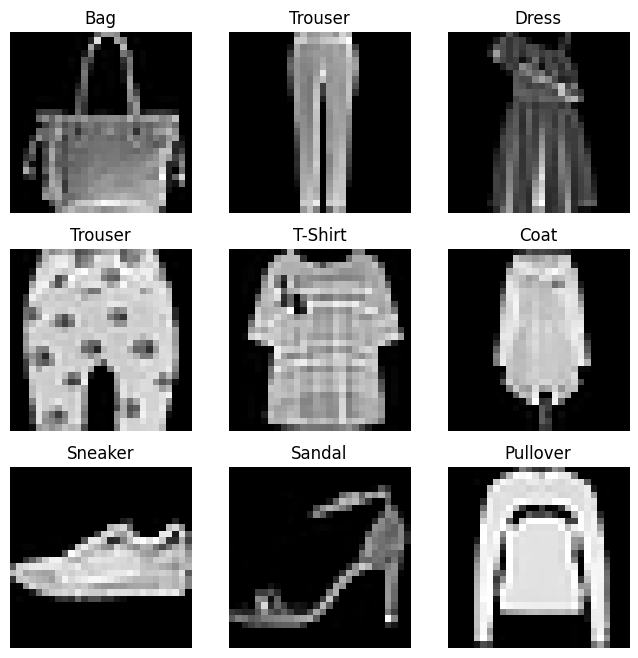

In [84]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
# 抽9幅图片并可视化出来
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, img_label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[img_label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 为您的文件创造自定义数据集

自定义数据集类必须实现三个函数: `__init__`, `__len__`, `__getitem__`。

In [85]:
import os
import pandas as pd
from torchvision.io import read_image

# FashionMNIST 实现
class CustomImageDataset(Dataset):
    
    def __init__(self, annotation_file, img_dir, transform=None, target_transform=None):
        self.image_labels = pd.read_csv(annotation_file)
        self.image_dir = img_dir
        # 样本转换器，一般是一个 callable 就行，相当于编码器：将图片转换为 tensor 等。
        self.transform = transform
        # 目标样本转换器
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.image_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.image_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label
        

## 使用 DataLoaders 准备数据进行训练

## 使用 DataLoader 迭代


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


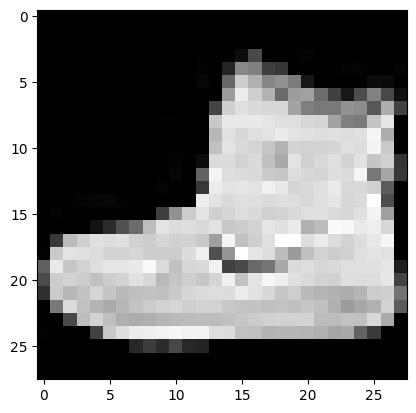

Label: 9


In [86]:
# Display image and label.
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# 4. Transform

ToTensor、Lambda

In [87]:
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [88]:
for k, v in ds:
    print(k, v)
    break

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

# 5. 建立神经网络

## 获取训练设备

In [89]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu')

print(f'使用 {device} 训练')

使用 mps 训练


## 定义类

使用 `nn.Module` 的子类来定义神经网络，并在 `__init__` 中初始化神经网络。每个 `nn.Module` 子类在 `forward` 方法
中实现对输入数据的操作。

In [90]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 扁平化，默认扁平化为一维
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

可以更改模型的训练设备:

In [91]:
model = NeuralNetwork().to(device)

model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

当我们传递输入数据值，会执行模型的 `forward`，以及一些后台操作，不要直接调用 `model.forward()`。

In [92]:
X = torch.rand(1, 28, 28, device=device)

logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)

y_pred

tensor([0], device='mps:0')

显示模型参数:

In [93]:
for name, param in model.named_parameters():
    print(f'Layer: {name} | Size: {param.size()} | Values: {param[:2]}')

Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values: tensor([[-0.0162, -0.0056, -0.0142,  ..., -0.0196,  0.0132, -0.0150],
        [ 0.0182,  0.0328,  0.0282,  ...,  0.0289, -0.0223, -0.0227]],
       device='mps:0', grad_fn=<SliceBackward0>)
Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values: tensor([0.0097, 0.0124], device='mps:0', grad_fn=<SliceBackward0>)
Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values: tensor([[ 0.0241,  0.0132,  0.0387,  ...,  0.0103,  0.0050,  0.0301],
        [-0.0079, -0.0111,  0.0128,  ...,  0.0043,  0.0168,  0.0391]],
       device='mps:0', grad_fn=<SliceBackward0>)
Layer: linear_relu_stack.2.bias | Size: torch.Size([512]) | Values: tensor([ 0.0200, -0.0193], device='mps:0', grad_fn=<SliceBackward0>)
Layer: linear_relu_stack.4.weight | Size: torch.Size([10, 512]) | Values: tensor([[ 0.0165,  0.0346,  0.0074,  ..., -0.0138,  0.0161,  0.0282],
        [ 0.0124,  0.0189, -0.0383,  ..., -0.0132, -0.

# 6. 自动区分 `torch.autograd`

PyTorch 有一个名为 `torch.autograd` 的内置微分引擎，它支持任何计算图的梯度自动计算。

In [94]:
import torch

x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)

In [95]:
z = x @ w + b

loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
loss

tensor(2.2179, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [96]:
z.grad_fn, loss.grad_fn

(<AddBackward0 at 0x293514a60>,
 <BinaryCrossEntropyWithLogitsBackward0 at 0x293516080>)

## 计算梯度

In [97]:
loss.backward()

w.grad, b.grad

(tensor([[0.3313, 0.2071, 0.1431],
         [0.3313, 0.2071, 0.1431],
         [0.3313, 0.2071, 0.1431],
         [0.3313, 0.2071, 0.1431],
         [0.3313, 0.2071, 0.1431]]),
 tensor([0.3313, 0.2071, 0.1431]))

## 禁用梯度跟踪

In [98]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


In [99]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


# 7. 优化模型参数

* epochs: 迭代次数
* batch_size: 批处理大小，样本数量
* learning_rate: 学习率

In [100]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

## 优化循环
每个循环都包含两个重要的参数:
* The Train Loop: 迭代训练数据集，并尝试收敛到最佳参数。
* The Validation/Test Loop: 迭代测试数据集，以检查模型性能是否正在提高。

## 损失函数

常见的损失函数包括用于回归任务的 `nn.MSELoss`（平均平方错误）和用于分类的 `nn.NLLLoss`（负对数可能性）。
`nn.CrossEntropyLoss` 结合了 `nn.LogSoftmax` 和 `nn.NLLLoss`。

我们将模型的输出 logit 传递给 `nn.CrossEntropyLoss`，这将使logit正常化并计算预测误差。

In [101]:
loss_fn = nn.CrossEntropyLoss()

## 优化器

所有优化逻辑都封装在 `optimizer` 对象中。在这里，我们使用SGD优化器；此外，PyTorch中有许多不同的优化器，如 `ADAM` 和 `RMSProp` ，它们更适用于不同类型的模型和数据。


In [102]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## 全面实施

In [103]:
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn, optimizer: torch.optim.Optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # 计算
        pred = model(X)
        # 损失函数
        loss = loss_fn(pred, y)
        
        # 传播
        loss.backward()
        # 收集梯度，调整参数
        optimizer.step()
        # 梯度归零
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader: DataLoader, model: nn.Module, loss_fn):
    model.eval()
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    
epochs = 10

model = model.to(device)

for t in range(epochs):
    train_loop(training_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
    
print("Done!")

loss: 2.294318  [   64/60000]
loss: 2.279976  [ 6464/60000]
loss: 2.258103  [12864/60000]
loss: 2.259092  [19264/60000]
loss: 2.239009  [25664/60000]
loss: 2.214313  [32064/60000]
loss: 2.221273  [38464/60000]
loss: 2.186905  [44864/60000]
loss: 2.179608  [51264/60000]
loss: 2.146931  [57664/60000]
Test Error: 
 Accuracy: 49.3%, Avg loss: 2.140845 

loss: 2.155710  [   64/60000]
loss: 2.142947  [ 6464/60000]
loss: 2.081255  [12864/60000]
loss: 2.097875  [19264/60000]
loss: 2.048521  [25664/60000]
loss: 1.991277  [32064/60000]
loss: 2.013248  [38464/60000]
loss: 1.938838  [44864/60000]
loss: 1.926498  [51264/60000]
loss: 1.851128  [57664/60000]
Test Error: 
 Accuracy: 61.0%, Avg loss: 1.855741 

loss: 1.895651  [   64/60000]
loss: 1.864016  [ 6464/60000]
loss: 1.742036  [12864/60000]
loss: 1.777261  [19264/60000]
loss: 1.678504  [25664/60000]
loss: 1.630444  [32064/60000]
loss: 1.638888  [38464/60000]
loss: 1.551071  [44864/60000]
loss: 1.557170  [51264/60000]
loss: 1.446563  [57664/600

# 8. 保存并加载模型

In [105]:
import torchvision.models as models

# model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model/model_weights.pth')

In [114]:
load_model = NeuralNetwork().to('mps')
load_model.load_state_dict(torch.load('model/model_weights.pth'))


tensor([[-3.3202e+00, -4.5739e+00, -2.2370e+00, -2.2068e+00, -1.6825e+00,
          4.8000e+00, -1.8904e+00,  4.3857e+00,  2.5438e+00,  5.2866e+00],
        [ 1.7661e+00, -4.0231e+00,  6.9929e+00, -8.8461e-01,  5.4995e+00,
         -3.5034e+00,  5.4542e+00, -9.1497e+00,  2.0230e+00, -4.7693e+00],
        [ 1.7346e+00,  8.9043e+00,  7.8760e-03,  5.1391e+00,  1.7825e+00,
         -4.4732e+00,  5.5923e-01, -5.4554e+00, -4.6510e+00, -4.4455e+00],
        [ 1.1316e+00,  6.9757e+00, -1.3950e-01,  4.0477e+00,  1.0689e+00,
         -3.1429e+00,  2.3478e-01, -3.9871e+00, -3.8080e+00, -3.1102e+00],
        [ 2.2519e+00, -2.1258e+00,  2.4761e+00,  2.3205e-01,  1.7527e+00,
         -1.6160e+00,  2.8801e+00, -5.0092e+00,  8.5849e-01, -1.9855e+00],
        [ 2.3901e+00,  6.2923e+00,  9.1322e-01,  3.9452e+00,  2.1777e+00,
         -4.2071e+00,  1.5019e+00, -5.8215e+00, -3.5663e+00, -4.3940e+00],
        [ 1.3236e+00, -7.0680e-01,  1.9686e+00,  6.2039e-02,  1.9924e+00,
         -1.3592e+00,  1.9748e+0

In [115]:
torch.save(model, 'model/model.pth')
load_model = torch.load('model/model.pth')

In [152]:

load_model.eval()
ret = []
for X, y in test_loader:
    X = X.to('mps')
    y = y.to('mps')
    model_ret = load_model(X) # type: torch.Tensor
    ret = model_ret.argmax(1) # type: torch.Tensor
    ret_label = [labels_map[i.item()] for i in ret]
    y_label = [labels_map[i.item()] for i in y.data]
    max = model_ret.max(1) # type: torch.return_types.max
    ret = np.array([ret_label, y_label, max[0].cpu().detach().numpy()])
    break
ret

array([['Ankle Boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt',
        'Trouser', 'Coat', 'Coat', 'Sneaker', 'Sneaker', 'Pullover',
        'Sandal', 'Sneaker', 'Dress', 'Coat', 'Trouser', 'Pullover',
        'Pullover', 'Bag', 'T-Shirt', 'Shirt', 'Sneaker', 'Sneaker',
        'Sneaker', 'Trouser', 'Pullover', 'Coat', 'Dress', 'Ankle Boot',
        'Dress', 'Bag', 'Bag', 'Dress', 'Dress', 'Bag', 'T-Shirt',
        'Sneaker', 'Sneaker', 'Sneaker', 'Ankle Boot', 'T-Shirt',
        'Trouser', 'Dress', 'Ankle Boot', 'Coat', 'Ankle Boot',
        'Pullover', 'Trouser', 'Coat', 'Pullover', 'Pullover',
        'Pullover', 'Sneaker', 'Shirt', 'Coat', 'Pullover', 'Bag',
        'Coat', 'Bag', 'T-Shirt', 'Sneaker', 'Sneaker', 'Bag', 'Sandal'],
       ['Ankle Boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt',
        'Trouser', 'Coat', 'Shirt', 'Sandal', 'Sneaker', 'Coat',
        'Sandal', 'Sneaker', 'Dress', 'Coat', 'Trouser', 'Pullover',
        'Coat', 'Bag', 'T-Shirt', 'Pullover', 'Sandal',